In [16]:
# Linear Regression model
import sys
import os
sys.path.append(os.path.abspath('..')) # adding path for packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import utils.data_preprocessing as dp
import numpy as np

In [17]:
data_X = dp.loadMatFile('../../Datasets/20110607S2_EEGandECoG_Su_Oosugi_ECoG128-EEG18/20110607S2_EEGECoG_Su_Oosugi_ECoG128-EEG18_mat/ECoG05_anesthesia.mat')
data_y = dp.loadMatFile('../../Datasets/20110607S2_EEGandECoG_Su_Oosugi_ECoG128-EEG18/20110607S2_EEGECoG_Su_Oosugi_ECoG128-EEG18_mat/EEG05_anesthesia.mat')
X = data_X[1]
y = data_y[1]
print(X.shape)
print(y.shape)

(129, 319234)
(19, 323262)


In [18]:
# downsample if mismatch in size of datasets
if data_X[1].shape[1] != data_y[1].shape[1]:
    # gaussian normalization
    if X.shape[1] > y.shape[1]:
        X = dp.downsample_data(X, y.shape[1])
    elif X.shape[1] < y.shape[1]:
        y = dp.downsample_data(y, X.shape[1])

(323262,)
(19, 323262)


In [19]:
X = X.T
y = y.T

# Split data into training, validation and test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# Normalize X
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

print("Train shapes:", X_train.shape, y_train.shape)
print("Validation shapes:", X_val.shape, y_val.shape)
print("Test shapes:", X_test.shape, y_test.shape)

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32)

Train shapes: (255387, 129) (255387, 19)
Validation shapes: (31923, 129) (31923, 19)
Test shapes: (31924, 129) (31924, 19)


In [49]:
# simple linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        # 1D Convolutional layers
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=129, out_channels=64, kernel_size=1, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=128, hidden_size=100, batch_first=True)
        
        # Fully connected layers
        self.fc1 = nn.Linear(100, 50)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(50, 19)
        
    def forward(self, x):
        # Convolutional layers
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        
        # Flatten the output of conv layers and prepare for LSTM
        x = x.permute(0, 2, 1)  # Change to (batch_size, sequence_length, features)
        
        # LSTM layer
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Take the output of the last time step
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [50]:
# instantiate the model
input_size = X_tensor.size(1)  # 129 (ecog)
output_size = y_tensor.size(1)  # 19 (eeg)
model = LinearRegressionModel()

# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# create DataLoader for batch processing
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64)

In [53]:
# Training loop RAW DATA
num_epochs = 200
loss_values = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for inputs, labels in dataloader:
        # Forward pass
        inputs = torch.unsqueeze(inputs, 1)
        print(inputs.shape)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Calculate average loss and mse for the epoch
    epoch_loss /= len(dataloader)

    # Append the loss values to the lists
    loss_values.append(epoch_loss)

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

torch.Size([64, 1, 129])


RuntimeError: Given groups=1, weight of size [64, 129, 1], expected input[64, 1, 129] to have 129 channels, but got 1 channels instead

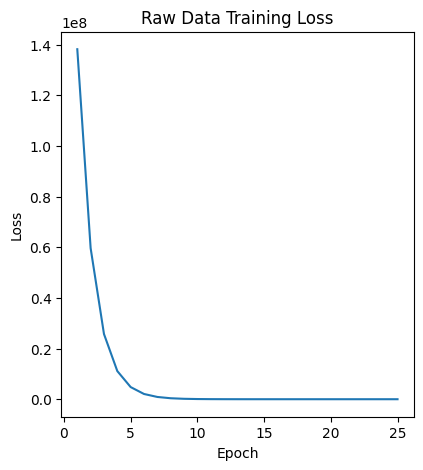

In [ ]:
# Plot loss function
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 25 + 1), loss_values[:25], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Raw Data Training Loss')
plt.show()

In [ ]:
# Evaluate on validation set
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Make predictions on validation set
model.eval()
with torch.no_grad():
    y_pred = model(X_val_tensor)
    val_loss = criterion(y_pred, y_val_tensor).item()
    
    y_pred_np = y_pred.numpy().T
    y_val_np = y_val_tensor.numpy().T
    
    corc = np.corrcoef(y_pred_np, y_val_np)
    corc = (corc + 1) / 2
    # average across rows
    electrode_corc = np.mean(corc, axis=1)
    print("accuracy per electrode: ")
    print(electrode_corc)
    overall_acc = np.mean(corc)
    
print(f"Test Error: \n Accuracy: {overall_acc:>0.2f}%, Avg loss: {val_loss:>8f} \n")

accuracy per electrode: 
[0.56538954 0.61906441 0.56547907 0.53627297 0.62726176 0.63844332
 0.62754452 0.46771229 0.66217535 0.62216783 0.525812   0.64685687
 0.64450243 0.66890614 0.66811864 0.66727856 0.6315827  0.66445542
 0.48543301 0.61501482 0.67165504 0.6332565  0.54600704 0.67566222
 0.67749257 0.67586848 0.42749155 0.6819713  0.64510043 0.39853008
 0.67679303 0.67429753 0.68257256 0.68452104 0.68540253 0.67418194
 0.6811467  0.51020138]
Test Error: 
 Accuracy: 0.62%, Avg loss: 27007.998047 



In [ ]:
# instantiate the model
input_size = X_tensor.size(1)  # 129 (ecog)
output_size = y_tensor.size(1)  # 19 (eeg)
preprocess_model = LinearRegressionModel(input_size, output_size)

# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
# possible hyperparameters
low_bound = 0.5
high_bound = 45
sampling_rate = 1000

# bandwidth_butterworth_filter
X_train_filtered = dp.butter_bandpass_filter(X_train.T, low_bound, high_bound, sampling_rate)
X_val_filtered = dp.butter_bandpass_filter(X_val.T, low_bound, high_bound, sampling_rate)

# PCA whitening
X_train_w = dp.whitening(X_train_filtered.T)
X_val_w = dp.whitening(X_val_filtered.T)

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X_train_w.T, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32)

print(X_tensor.size(1))
print(y_tensor.size(1))
# create DataLoader for batch processing
processed_dataset = TensorDataset(X_tensor, y_tensor)
processed_dataloader = DataLoader(dataset, batch_size=64)



[1.86497381e+00 1.47191709e+00 8.50478830e-01 7.50875894e-01
 5.80616818e-01 4.70237210e-01 3.55315518e-01 3.39930883e-01
 2.70407411e-01 2.47701444e-01 2.35061177e-01 2.16933061e-01
 1.70456420e-01 1.65216661e-01 1.50048944e-01 1.39484509e-01
 1.31086903e-01 1.29173955e-01 1.18667804e-01 1.10256812e-01
 1.05977121e-01 9.92057762e-02 9.57938664e-02 9.39095685e-02
 9.07827076e-02 7.98009666e-02 7.89195199e-02 7.64931137e-02
 7.60816215e-02 7.35535961e-02 7.09645727e-02 6.87335302e-02
 6.50639985e-02 6.32464649e-02 6.02993495e-02 5.96027582e-02
 5.67170771e-02 5.42390583e-02 5.13187677e-02 5.02612356e-02
 4.97971554e-02 4.84724445e-02 4.50505171e-02 4.29343250e-02
 4.20487367e-02 4.02275088e-02 3.91327846e-02 3.87605412e-02
 3.73842792e-02 3.59507662e-02 3.49486536e-02 3.45086065e-02
 3.29091713e-02 3.18557621e-02 3.11240966e-02 2.96877561e-02
 2.91093072e-02 2.88755928e-02 2.80198059e-02 2.70658650e-02
 2.64657889e-02 2.59034363e-02 2.39880511e-02 2.38078886e-02
 2.29428999e-02 2.273785

In [ ]:
# Training loop PREPROCESSED DATA
num_epochs = 200
loss_values = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for inputs, labels in processed_dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Calculate average loss and mse for the epoch
    epoch_loss /= len(processed_dataloader)

    # Append the loss values to the lists
    loss_values.append(epoch_loss)

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [10/200], Loss: 27155.2396
Epoch [20/200], Loss: 27153.7259
Epoch [30/200], Loss: 27152.3286
Epoch [40/200], Loss: 27151.0348
Epoch [50/200], Loss: 27149.8349
Epoch [60/200], Loss: 27148.7193
Epoch [70/200], Loss: 27147.6804


KeyboardInterrupt: 

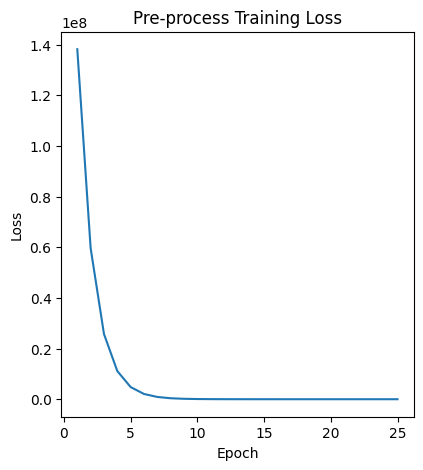

In [ ]:
# Plot loss function
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 25 + 1), loss_values[:25], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pre-process Training Loss')
plt.show()

In [ ]:
# Evaluate on validation set
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Make predictions on validation set
model.eval()
with torch.no_grad():
    y_pred = model(X_val_tensor)
    val_loss = criterion(y_pred, y_val_tensor).item()
    
    y_pred_np = y_pred.numpy().T
    y_val_np = y_val_tensor.numpy().T
    
    corc = np.corrcoef(y_pred_np, y_val_np)
    corc = (corc + 1) / 2
    # average across rows
    electrode_corc = np.mean(corc, axis=1)
    print("accuracy per electrode: ")
    print(electrode_corc)
    overall_acc = np.mean(corc)
    
print(f"Test Error: \n Accuracy: {overall_acc:>0.4f}%, Avg loss: {val_loss:>8f} \n")

accuracy per electrode: 
[0.59821239 0.64762219 0.61734214 0.57280512 0.64983227 0.64990679
 0.64537307 0.41887121 0.64334963 0.58250406 0.39660444 0.65128125
 0.64949378 0.65799558 0.65738152 0.65727894 0.6507965  0.65465697
 0.51653187 0.59764491 0.65269095 0.61955781 0.54132001 0.65496216
 0.65750945 0.65413003 0.43230688 0.65892695 0.60972831 0.3931737
 0.65496369 0.65300858 0.65914819 0.65909323 0.65889404 0.65476705
 0.6568584  0.51152749]
Test Error: 
 Accuracy: 0.6078%, Avg loss: 28152.369141 

